# Portrait dataset preprocessing
### Import

In [1]:
from tensorboard.plugins.histogram.summary import histogram
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from data_utils import stat_unique, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,split_small_data_vertically


import json
import pandas as pd
import numpy as np

In [3]:
header_names = ['user_id', 'item_id', 'dimension_id', 'correct']
raw_data = pd.read_csv('portrait_prepro.csv', encoding="ISO-8859-15", low_memory=False, names=header_names)
raw_data = raw_data[1:]
raw_data.head()

/tmp/ipykernel_69373/2970409252.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  raw_data = raw_data[1:]


,user_id,item_id,dimension_id,correct
1.0,17,TR01,TR,3.9
2.0,17,TR02,TR,2.5
3.0,17,TR03,TR,1.3
4.0,17,TR04,TR,5.7
5.0,17,TR05,TR,5.9


In [3]:
print(len(raw_data))
all_data = raw_data.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

259200
259200


In [4]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 259200
Number of unique [user_id,item_id]: 259200
Number of unique user_id: 1152
Number of unique item_id: 225
Number of unique dimension_id: 14


### Clean Nan values

In [5]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','dimension_id','correct'], axis='index')

### Remove duplicated user and id rows

In [6]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])
unduplicated_data['correct'] = unduplicated_data['correct'].astype(float)

### Reverse items formulated in the opposite meaning

In [7]:
reverse_data = unduplicated_data.copy()
list_reverse_items = ['TR5','TR10','T15','TR16','ST10','DI13','BU5','BU6','IM13','HY7','AU4','AU6','AU19','PO13','CO2','AD12','HU7','HU9','HU10',]

c_r = reverse_data[reverse_data['item_id'].isin(list_reverse_items)]['correct'] 
reverse_data.loc[reverse_data['item_id'].isin(list_reverse_items),'correct'] = c_r.apply(lambda x : 10-x)
reverse_data[reverse_data['item_id'].isin(list_reverse_items)]['correct'].mean()

3.4667052469135804

### Filter Data

In [8]:
# Remove items with way to high imbalanced classes (unrelevant questions)
f = reverse_data.copy()

a = ((unduplicated_data.groupby('item_id')['correct'].quantile(0.5)))
f = f[f['item_id'].isin(list(a[a>1].index))]

In [9]:
filtered_data_0 = f.copy()
filtered_user_nb = 1
filtered_item_nb = 0
filtered_dimension_nb = 0

while filtered_user_nb!=0 or filtered_item_nb!=0 or filtered_dimension_nb!=0: 
    # filter items
    filtered_data_1, filtered_user_nb = densify(filtered_data_0,'item_id','user_id',50)
    # filter users
    filtered_data_2, filtered_item_nb = densify(filtered_data_1,'user_id','item_id',50)
    # filter knowledges
    filtered_data_3, filtered_dimension_nb = densify(filtered_data_2,'dimension_id','item_id',10)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 0 item_id
filter 0 user_id
filter 5 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 133632
Number of unique [user_id,item_id]: 133632
Number of unique user_id: 1152
Number of unique item_id: 116
Number of unique dimension_id: 9


### Encoding

In [11]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [12]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [13]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [14]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [15]:
d_enc_data['correct'] = d_enc_data['correct'].astype(float)
min_val = d_enc_data['correct'].min()
max_val = d_enc_data['correct'].max()
d_enc_data['correct'] = (d_enc_data['correct']-min_val)/(max_val-min_val) +1
shifted_values = d_enc_data.copy()
print(f'min value : {shifted_values["correct"].min()}, max value : {shifted_values["correct"].max()}')

min value : 1.0, max value : 2.0


In [16]:
print(f'min value : {shifted_values["correct"].min()}, max value : {shifted_values["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [17]:
stat_unique(shifted_values, None)
stat_unique(shifted_values, ['user_id', 'item_id'])
stat_unique(shifted_values, 'user_id')
stat_unique(shifted_values, 'item_id')
stat_unique(shifted_values, 'dimension_id')
stat_unique(shifted_values, 'correct')

shifted_values_dim_grouped_items = shifted_values.groupby("dimension_id")["item_id"].nunique()
shifted_values_dim_grouped_users = shifted_values.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_items),int(np.round(np.mean(shifted_values_dim_grouped_items))),np.max(shifted_values_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_users),int(np.round(np.mean(shifted_values_dim_grouped_users))),np.max(shifted_values_dim_grouped_users)))

shifted_values_dim_grouped_items = shifted_values.groupby("item_id")["dimension_id"].nunique()
shifted_values_dim_grouped_users = shifted_values.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_items),int(np.round(np.mean(shifted_values_dim_grouped_items))),np.max(shifted_values_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_users),int(np.round(np.mean(shifted_values_dim_grouped_users))),np.max(shifted_values_dim_grouped_users)))

shifted_values_dim_grouped_items = shifted_values.groupby("user_id")["item_id"].nunique()
shifted_values_dim_grouped_users = shifted_values.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_items),int(np.round(np.mean(shifted_values_dim_grouped_items))),np.max(shifted_values_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(shifted_values_dim_grouped_users),int(np.round(np.mean(shifted_values_dim_grouped_users))),np.max(shifted_values_dim_grouped_users)))

Total length: 133632
Number of unique [user_id,item_id]: 133632
Number of unique user_id: 1152
Number of unique item_id: 116
Number of unique dimension_id: 9
Number of unique correct: 108
#questions/category: 10 & 13 &  18
#users/category: 1152 & 1152 &  1152
#categorys/question: 1 & 1 &  1
#users/question: 1152 & 1152 &  1152
#questions/users: 116 & 116 &  116
#categorys/users: 9 & 9 &  9


Text(0.5, 1.0, 'Distribution of Responses')

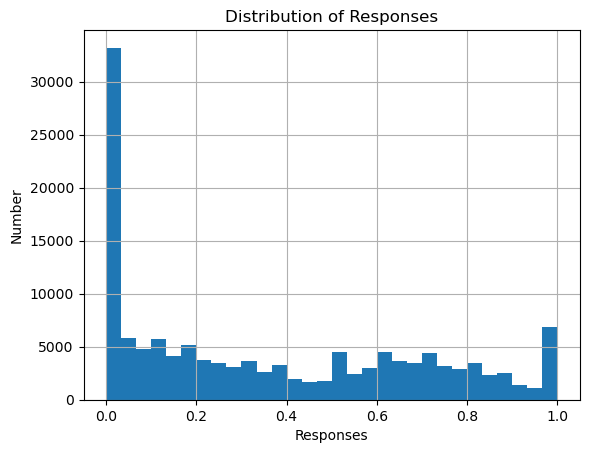

In [18]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(shifted_values['correct']-1).hist(bins=30)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


In [72]:
metadata = get_metadata(shifted_values,["user_id", "item_id", "dimension_id"])

### Save data, concept map and metadata

In [73]:
# save selected data
shifted_values.to_csv('selected_data.csv', index=False)

In [74]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [75]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

## Parse data

In [76]:
shifted_values = pd.read_csv('selected_data.csv')
quadruplets = quadruplet_format(shifted_values)

In [77]:
stu_data, ques_data = parse_data(shifted_values)

In [78]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=150

## Split data

### Horizontal split

In [ ]:
train_data, valid_data, test_data = split_data(quadruplets, stu_data, test_prop=0.2,valid_prop=0.2, least_test_length=150) 

In [ ]:
print(f'train records length: {len(train_data)}')
print(f'test records length: {len(test_data)}')
print(f'test records length: {len(valid_data)}')
print(f'all records length: {len(train_data)+len(valid_data)+len(test_data)}')

In [ ]:
# save
save_to_csv(train_data, '../2-preprocessed_data/portrait_train_quadruples.csv')
save_to_csv(valid_data, '../2-preprocessed_data/portrait_valid_quadruples.csv')
save_to_csv(test_data, '../2-preprocessed_data/portrait_test_quadruples.csv')

### Vertical split

In [79]:
train_data, valid_data, test_data = split_data_vertically(quadruplets, test_prop=0.2,valid_prop=0.2, folds_nb=5)
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/portrait_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/portrait_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/portrait_test_quadruples_vert_{i_fold}.csv')

#### Toy dataset generation

In [80]:
train_data_small, valid_data_small, test_data_small = split_small_data_vertically(quadruplets, test_prop=0.8,valid_prop=0.1)

save_to_csv(train_data_small, f'../2-preprocessed_data/portrait_small_train_quadruples_vert_{0}.csv')
save_to_csv(valid_data_small, f'../2-preprocessed_data/portrait_small_valid_quadruples_vert_{0}.csv')
save_to_csv(test_data_small, f'../2-preprocessed_data/portrait_small_test_quadruples_vert_{0}.csv')

### convert responses to one hot encoding

In [ ]:
def one_hot_encoding(df):
    c_binary_list = []
    for index, row in df.iterrows():
        c = row['correct_rounded']
        for i in range(11):
            if i ==c:
                c_binary_list.append(1)
            else:
                c_binary_list.append(0)
                
    duplicated_df = pd.DataFrame(np.repeat(df.values, 11, axis=0), columns=df.columns)
    duplicated_df = duplicated_df.astype({'item_id': 'int32'})
    duplicated_df = duplicated_df.astype({'item_id': 'str'})
    for index, row in duplicated_df.iterrows():
        i = index % 11
        orig_q_id = row['item_id']
        duplicated_df.at[index, 'item_id'] = str(orig_q_id) + '_' + str(i)
        duplicated_df.at[index, 'correct_binary'] = int(c_binary_list[index])
    return duplicated_df

In [ ]:
train = pd.read_csv("../2-preprocessed_data/portrait_train_quadruples.csv")
train['correct_rounded'] = train['correct'].round().astype(int)

In [ ]:
import numpy as np

duplicated_train = one_hot_encoding(train)

In [ ]:
duplicated_train.drop('correct_rounded', axis=1, inplace=True)

In [ ]:
duplicated_train.to_csv('../2-preprocessed_data/portrait_train_quadruples.csv', index=False)

In [ ]:
valid = pd.read_csv("../2-preprocessed_data/portrait_valid_quadruples.csv")
valid['correct_rounded'] = valid['correct'].round().astype(int)

In [ ]:
duplicated_valid = one_hot_encoding(valid)

In [ ]:
duplicated_valid.drop('correct_rounded', axis=1, inplace=True)

In [ ]:
duplicated_valid.to_csv('../2-preprocessed_data/portrait_valid_quadruples.csv', index=False)

In [ ]:
test = pd.read_csv("../2-preprocessed_data/portrait_test_quadruples.csv")
test['correct_rounded'] = test['correct'].round().astype(int)

In [ ]:
duplicated_test = one_hot_encoding(test)

In [ ]:
duplicated_test.drop('correct_rounded', axis=1, inplace=True)

In [ ]:
duplicated_test.to_csv('../2-preprocessed_data/portrait_test_quadruples.csv', index=False)

In [ ]:
for i_fold in range(5):
    train = pd.read_csv(f"../2-preprocessed_data/portrait_train_quadruples_vert_{i_fold}.csv")
    train['correct_rounded'] = train['correct'].round().astype(int)
    duplicated_train.drop('correct_rounded', axis=1, inplace=True)
    duplicated_train.to_csv(f'../2-preprocessed_data/portrait_train_quadruples_vert_{i_fold}.csv', index=False)
    
    valid = pd.read_csv(f"../2-preprocessed_data/portrait_valid_quadruples_vert_{i_fold}.csv")
    valid['correct_rounded'] = valid['correct'].round().astype(int)
    duplicated_valid.drop('correct_rounded', axis=1, inplace=True)
    duplicated_valid.to_csv(f'../2-preprocessed_data/portrait_valid_quadruples_vert_{i_fold}.csv', index=False)
    
    test = pd.read_csv(f"../2-preprocessed_data/portrait_test_quadruples_vert_{i_fold}.csv")
    test['correct_rounded'] = test['correct'].round().astype(int)
    duplicated_test.drop('correct_rounded', axis=1, inplace=True)
    duplicated_test.to_csv(f'../2-preprocessed_data/portrait_test_quadruples_vert_{i_fold}.csv', index=False)